## Car Sales Prediction  

### Code Developer : MJ Pakdel, 3/13/2020

### Problem Statement 

- An external client at company x is ineterested to know how the probability of sell of each offer is impacted by car and auction characteristics. There are 4 main questions to investigate:

- Q1) How the probability of sell of each offering is impacted by the floor price(with respect to MMR (Manheim Market Report)?

- Q2) What the other factors that also impact the probablity of sell?

- Q3) What is the probability of sell ? 

- Q4) Quantifiy the accuracy of the model ?


## Outline

#### Chapter 1 : Data expoleration 
#### Chapter 2 : Classification Performance Metrics 
#### Chapter 3 : Sales Probability Discussion (Logistic Regression)
#### Chapter 4 : Implementation of Bucket of Models 
* Logistic
* Deciosn trees
* Random Forest
* SVM
* KNN
* Naive Bayes Classifier
* Deep learning

#### Chapter 5 : What is the Take for a Client
#### Chapter 6 : Recommendation for Future Research 
</font></p>

In [1]:
# Import common libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import datetime
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, precision_score,recall_score,accuracy_score,roc_auc_score
from collections import OrderedDict
import warnings
from sklearn.linear_model import LogisticRegression
from IPython.display import Image
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
%matplotlib inline

In [2]:
# set pandas display parameters

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 500)
plt.rc("font", size=15)
warnings.filterwarnings('ignore')
seed = 100

#percentage of data points in test dataset
test_train_split_threshold = 0.2

# This empty list is used to used to store the accurace metrics of current execution

added_report_lst = []

### Helper Functions

In [3]:
def convert_column_into_lowercase(df,*cols):
    
    """
    Converts the entire column into a lowercase string
    
    Args:
    -----
    df: a pandas data frame object
    cols: a list of columns names
        
    Returns:
    --------
    A pandas dataframe with columns turned into lowercase
    """
    for col in cols:
        df[col] = df[col].str.lower()
        
    return df

In [4]:
def column_refactor(df,col,number_of_levels_keps,refactore_level,new_col_name):
    
    """
    For a given column name and a given number_of_levels only keeps columns that are frequent. levels that are 
    rate are replaced with refactore_level. For example if number_of_levels is 40 and refactored_level is 'other', 
    only 40 most frethey levels are kept and the rest will be collapsed into 'other' category
    
    Args:
    -----
    df: a pandas data frame object
    number_of_levels_keps : an integer that shows the number of levels to keep
    refactore_level : it could be df[col_name] or 'missing'
    new_col_name: a string that specifies that name of the new column
        
    Returns:
    --------
    A pandas dataframe with added column new_col_name
    """
        
    lst = list(df[col].value_counts()[0:number_of_levels_keps].index)
    df[new_col_name] = np.where(df[col].isin(lst),df[col],refactore_level)
    return df

In [5]:
def compute_days(cols):
    """
    For a list that has the col_names for arrival data nd offer date, it computes how many days are
    between arrival and offer
    
    Args:
    -----
    cols: a list of strings. first element represents the column name for offer date and second element represents 
        the arrival date. Dates are supposed to have '%Y%m%d' format
        
    Returns:
    --------
    An integer represents the number of days between arrival and offer
    """
    
    return (datetime.datetime.strptime(str(cols[1]),'%Y%m%d')-datetime.datetime.strptime(str(cols[0]),'%Y%m%d')).days

In [6]:
def extract_hour(cols):
    """
    For a string representing a column name (timestamp of being sold), it extract the hour of being sold
    
    Args:
    -----
    cols: a list of column name that represent the timestamp of time being sold. Dates are supposed to have 
    '%d%b%Y:%H:%M:%S' format
        
    Returns:
    --------
    A string that represnt the hour time of being sold
    """

    if len(str(cols[0]))<4:
        pass
    else:
        return (datetime.datetime.strptime(str(cols[0]),'%d%b%Y:%H:%M:%S')).strftime('%H%p')

In [7]:
def standardize_df(df_name):
    
    """
    For a given dataframe, this function standardize dataframe. Columns are assumed to be continuous. The library
    StandardScalar of python is used for this purpose. Returned columns will have mean of 0 and std of 1
    
    
    Args:
    -----
    df: a pandas data frame object
        
    Returns:
    --------
    A pandas dataframe with standardized features
    """
    

    
    scaler = StandardScaler()
    scaler.fit(df_name)
    scaled_features = scaler.transform(df_name)
    
    df_feat = pd.DataFrame(scaled_features,columns=df_name.columns)
    return df_feat

In [8]:
def SMOTE_resampling(train_x,train_y):
    """
    For a given x_train and y_train dataframes, it reweights the less frequent class in a way that both classes
    will be 50/50
    
    
    Args:
    -----
    train_x: a pandas dataframe that includes all features
    train_y: a pandas dataframe that includes y for training dataset
        
    Returns:
    --------
    Two reweighted pandas dataframe, one for features and one for response
    """
    
    
    columns = train_x.columns
    os = SMOTE(random_state = seed)
    
    os_data_X,os_data_y=os.fit_sample(train_x, train_y)
    
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y)
    return os_data_X,os_data_y

In [9]:
def replace_nans_categorical(df,*cols):
    
    """
    For a given dataframe and a list of categorical variables in that dataframe, this function 
    replaces all missing values with string 'missing'. 
    
    
    Args:
    -----
    df: a pandas data frame object
    cols: a list of categorical variables with missing values
        
    Returns:
    --------
    
    """   


    
    for col in cols:
        df[col] = np.where(df[col].isnull(),'missing',df[col])

In [10]:
def replace_nans_continuous(df,cols):
    
    """
    For a given dataframe and a list of continuous variables in that dataframe, this function 
    imputes the missing values using all other continuous variables. 
    
    
    Args:
    -----
    df: a pandas data frame object
    cols: a list of continuous variables with missing values
        
    Returns:
    --------
    a pandas dataframe with all missing values in the given list imputed
    """
    
    imp = IterativeImputer(max_iter=10, random_state=0)
    temp_df = df[cols]
    temp_array = np.array(temp_df)
    
    imp.fit(temp_array)
    IterativeImputer(random_state=0)
    # the model learns that the second feature is double the first
    imputed_temp_array = (np.round(imp.transform(temp_array)))
    
    temp_df1 = pd.DataFrame(imputed_temp_array,columns=temp_df.columns)
    return temp_df1

In [11]:
def report_classification_metrics(y,y_hat,model_name,standardize_feature , reweight_training,number_of_featurs,best_params):
    """
    This function reports classification error, 
    precision, recall, and f1_score and area under the roc curve in a dictionary format for the model of interest
    
    
    Args:
    -----
    y: a pandas dataframe that has y_test
    y_hat: a pandas dataframe that has prediction for X_test
    model_name : a string,
    standardize_feature : boolean
    reweight_training : boolean
    number_of_featurs : an integer to show how many features are used in the model
    best_params : a dictionary that has model hyper parameters
    
        
    Returns:
    --------
    A dictionary with all included metrics
    """
    
    metric_dic = OrderedDict()
    
    metric_dic['model_name'] = model_name
    metric_dic['test_train_split_threshold'] = test_train_split_threshold
    metric_dic['standardize_feature'] = standardize_feature
    metric_dic['reweight_training'] = reweight_training
    metric_dic['number_of_featurs'] = number_of_featurs
    metric_dic['best_params'] = best_params
    
    
    metric_dic['model_accuracy'] = str(accuracy_score(y,y_hat))[0:6]
    metric_dic['model_precision'] = str(precision_score(y,y_hat))[0:6]
    metric_dic['model_recall'] = str(recall_score(y,y_hat))[0:6]
    metric_dic['model_f1_score'] = str(f1_score(y,y_hat))[0:6]
    metric_dic['auc_under_roc'] = str(roc_auc_score(y,y_hat))[0:6]
    
#     added_report_lst.append(metric_dic)
    
 
    return metric_dic

In [12]:
def hyper_parameter_optimizer(model_name,hyperparameters,n_fold,search_type):
    """
    This function finds the best hyper parameters for the model of interest and report them back in a dictionary
    
    
    Args:
    -----
    model_name: a python object that identifies the model that we want to tune
    hyperparameters: a dictionary with all hyperparameters we want to search
    n_fold: : an integer that shows the number of folds in kfold cross validation
    search_type: a string that specifies the type of search, it could be either 'RandomizedSearchCV'
    or 'GridSearchCV'
        
    Returns:
    --------
    A dictionary with optimal parameters
    """
    
    if search_type == 'RandomizedSearchCV':
        cv_conf = RandomizedSearchCV(estimator = model_name, param_distributions = hyperparameters, n_iter = 100, cv = n_fold, 
                       verbose=2, random_state=42)
    else:
        cv_conf = GridSearchCV(model_name, hyperparameters, cv = n_fold, verbose = 0)

    best_model = cv_conf.fit(X_train,y_train)
    best_params = best_model.best_params_
        
    return best_params

In [13]:
def f1_score_calulator(lst):
    
    """
    This function return the f1 score computed using logistic lasso regression for 
    different levels of C parameter. C parameter is used to penelize overfitting in lasso
    regression. Smaller C means that fewerer coeefficients will be set to 0
    
    
    Args:
    -----
    lst: a python list that has all C parameters we want to investigate
        
    Returns:
    --------
    A dictionary whose each key is the number of features removed using the C parameter and 
    values will be the corresponding training error
    """
    
    
    f1_score_dic = OrderedDict()
    for c in lst:
        X = df
        #Split training and test dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_train_split_threshold, random_state = seed)
        
        X_train.reset_index(inplace = True,drop = True)
        X_test.reset_index(inplace = True,drop = True)
        
        X_train[x_continuous_feature] = standardize_df(X_train[x_continuous_feature])
        X_test[x_continuous_feature] = standardize_df(X_test[x_continuous_feature])

        
        # Running a Lasso Logistic regression to find out which features should be included
        logmodel = LogisticRegression( penalty = 'l1',solver = 'liblinear',C= c)
        # Fitting model to traing data
        logmodel.fit(X_train,y_train)
        
        #selected_feature_list has all included features        
        log_model_coeff = logmodel.coef_[0].tolist()
        selected_features = [col for index,col in enumerate(X_train.columns) if log_model_coeff[index] != 0 ]
      
        X =X[selected_features]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_train_split_threshold, random_state = seed)
        
        X_train.reset_index(inplace = True,drop = True)
        X_test.reset_index(inplace = True,drop = True)
        
        X_train[[i for i in x_continuous_feature if i in selected_features]] = standardize_df(X_train[[i for i in x_continuous_feature if i in selected_features]])
        X_test[[i for i in x_continuous_feature if i in selected_features]] = standardize_df(X_test[[i for i in x_continuous_feature if i in selected_features]])

        
        
        # define the base model
        logmodel = LogisticRegression()
        
        # Retrain the model using the best parameters
        logmodel = LogisticRegression()
        # Fitting model to traing data
        logmodel.fit(X_train,y_train)
        # Predict test data using the trained model
        predictions = logmodel.predict(X_train)
        
        f1_score_dic[df.shape[1]-X_test.shape[1]] = report_classification_metrics(y_train,predictions,'logit',True,False,X_test.shape[1],'')['model_f1_score']
        
       
    return  f1_score_dic  

In [14]:
def add_results_to_historical_runs(add_to_results,model_metrics):
    
    """
    This function adds the result of the most recent fitted model to a pandas 
    dataframe that has the results of the historical runs
    
    
    Args:
    -----
    add_to_results: a Boolean specifying whether or not add current model to historical ones
        
    Returns:
    --------

    """
    
    global report_data_frame
    
    
    if add_to_results:
        added_report_lst = []
        added_report_lst.append(model_metrics)
        report_data_frame = report_data_frame.append(pd.DataFrame(added_report_lst))

### Data Manipulation

In [15]:
# Read the data in an excel file

df = pd.read_excel('commercial_sale_data.xlsx')
print('the size of pandas dataframe is : ', df.shape)
df[0:4]

the size of pandas dataframe is :  (40403, 39)


,sauci,auctionname,auctioncity,swo,sdtesa,arrivaldate,sser17,JD_POWERS_CAT_DESC,JD_POWERS_SUB_CAT_DESC,dmpostcond,dmprecond,smiles,color,dmsold,MID,MID_YEAR,MID_MAKE,MID_MODEL,MID_BODY,ch_make,ch_model,ch_body,sfloor,stime,SALE_NUM,LANE_NUM,RUN_NUM,sflndr,RED_LIGHT,YELLOW_LIGHT,YMM,volseg,Velocity,DSO,MMR,AdjMMR,SREMAR,SANNOU,abnormal
0,RAA,Manheim Riverside,Riverside,2291908,20161115,20161103,19XFB2F89DE258267,COMPACT CAR,PREMIUM,3.80,3.60,44169,Gray,1,201302301661458,2013,HONDA,CIVIC,4D SEDAN EX,Honda,Civic Sdn,Sedan,"9,500.00",15NOV2016:13:53:02,46,8,143,R,N,N,2013_Honda_CivicSdn,Tier1,Hot,nan,"10,375.00","10,632.00",NaN,DMV$133,0
1,MAAI,Manheim Minneapolis,Maple Grove,2388041,20160727,20160709,1C3CCBBB3DN689978,MIDSIZE CAR,PREMIUM,4.20,4.20,52753,White,1,201301254051229,2013,CHRYSLER,200 4C,4D SEDAN TOURING,Chrysler,200,Sedan,"7,800.00",27JUL2016:10:38:25,30,22,11,R,N,N,2013_Chrysler_200,Tier1,Hot,nan,"8,046.00","8,658.00",NaN,NaN,0
2,DALA,Manheim Dallas,Dallas,4741877,20160831,20160812,1C3CCCAB2FN689464,MIDSIZE CAR,PREMIUM,3.40,3.40,21914,White,1,201501268701389,2015,CHRYSLER,200 FWD 4C,4D SEDAN LIMITED,Chrysler,200,Sedan,"11,500.00",31AUG2016:11:21:30,35,2,59,R,N,N,2015_Chrysler_200,Tier1,Warm,nan,"11,484.00","11,457.00",NaN,NaN,0
3,FAAO,Manheim Orlando,Ocoee,3479240,20161129,20161102,1C3CCCAB9FN612381,MIDSIZE CAR,PREMIUM,2.00,2.00,53307,White,1,201501268701389,2015,CHRYSLER,200 FWD 4C,4D SEDAN LIMITED,Chrysler,200,Sedan,"8,000.00",29NOV2016:11:32:47,48,19,305,R,N,N,2015_Chrysler_200,Tier1,Warm,nan,"9,130.00","7,681.00",NaN,NaN,0


In [16]:
# Here the software looks into current directory of the jupyter notebook, if a file named
# different_models_evaluations exists, the software read it and the metrics for new fitted models
# will be added to historical model results. Otherwise, the file is going to be created. 

try :
    report_data_frame = pd.read_csv('different_models_evaluations.csv')
except:
    print('No csv file with the output of historical runs exists in current directory')
    report_data_frame = pd.DataFrame()

In [18]:
# variable auction city is renamed city and dmsold is renamed sold

map_col_dic = {
    'auctioncity' : 'city',
    'dmsold' : 'sold'
}

df = df.rename(columns = map_col_dic)

In [19]:
# columns of make, model and body are converted to lower case strings

df = convert_column_into_lowercase(df,'MID_MAKE','MID_MODEL','MID_BODY','ch_make','ch_model','ch_body')

In [20]:
# These two functions extract hours of sell and number of days between arrrival and offer. 

df['sold_hour'] = df[['stime']].apply(extract_hour,axis = 1)
df['days_between_arrival_and_offer'] = df[['arrivaldate','sdtesa']].apply(compute_days,axis = 1)

In [21]:

# Any color that is in list ['Unknown','Yellow','Off-white','Turquoise'] is replaced with 'other' string
df['color'] = np.where(df['color'].isin(['Unknown','Yellow','Off-white','Turquoise']),'other',df['color'])

# Any sold_hour that is in list ['08AM','15PM','16PM','17PM','18PM','19PM'] is replaced with 'other' string
df['sold_hour'] = np.where(df['sold_hour'].isin(['08AM','15PM','16PM','17PM','18PM','19PM']),'other',df['sold_hour'])

# whenever mid_year is equal to -1, MID_MODEL and MID_BODY are missing. Instead ch_model and ch_body is used
df['MID_MODEL'] = np.where(df['MID_YEAR'] == -1,df['ch_model'],df['MID_MODEL'])
df['MID_BODY'] = np.where(df['MID_YEAR'] == -1,df['ch_body'],df['MID_MODEL'])

# Any MID_YEAR that is in list [2007,2008,2009,2010,2011,2017] is replaced with 'other' string
df['MID_YEAR'] = np.where(df['MID_YEAR'].isin([2007,2008,2009,2010,2011,2017]),'other',df['MID_YEAR'])

# Any make except ['hyundai','kia'] is collapsed into 'ohter' string
df['make'] = np.where(df['MID_MAKE'].isin(['hyundai','kia']),df['ch_make'],'other')

# Any model that is not among first 35 most frequent model is bucketed into 'other' string.
df = column_refactor(df,'MID_MODEL',35,'other','model')
# Any body that is not among first 35 most frequent model is set to ch_body which is less granular than MID_BODY.
df = column_refactor(df,'MID_BODY',40,df['ch_body'],'body')
df[0:3]

,sauci,auctionname,city,swo,sdtesa,arrivaldate,sser17,JD_POWERS_CAT_DESC,JD_POWERS_SUB_CAT_DESC,dmpostcond,dmprecond,smiles,color,sold,MID,MID_YEAR,MID_MAKE,MID_MODEL,MID_BODY,ch_make,ch_model,ch_body,sfloor,stime,SALE_NUM,LANE_NUM,RUN_NUM,sflndr,RED_LIGHT,YELLOW_LIGHT,YMM,volseg,Velocity,DSO,MMR,AdjMMR,SREMAR,SANNOU,abnormal,sold_hour,days_between_arrival_and_offer,make,model,body
0,RAA,Manheim Riverside,Riverside,2291908,20161115,20161103,19XFB2F89DE258267,COMPACT CAR,PREMIUM,3.80,3.60,44169,Gray,1,201302301661458,2013,honda,civic,civic,honda,civic sdn,sedan,"9,500.00",15NOV2016:13:53:02,46,8,143,R,N,N,2013_Honda_CivicSdn,Tier1,Hot,nan,"10,375.00","10,632.00",NaN,DMV$133,0,13PM,12,other,other,sedan
1,MAAI,Manheim Minneapolis,Maple Grove,2388041,20160727,20160709,1C3CCBBB3DN689978,MIDSIZE CAR,PREMIUM,4.20,4.20,52753,White,1,201301254051229,2013,chrysler,200 4c,200 4c,chrysler,NaN,sedan,"7,800.00",27JUL2016:10:38:25,30,22,11,R,N,N,2013_Chrysler_200,Tier1,Hot,nan,"8,046.00","8,658.00",NaN,NaN,0,10AM,18,other,other,sedan
2,DALA,Manheim Dallas,Dallas,4741877,20160831,20160812,1C3CCCAB2FN689464,MIDSIZE CAR,PREMIUM,3.40,3.40,21914,White,1,201501268701389,2015,chrysler,200 fwd 4c,200 fwd 4c,chrysler,NaN,sedan,"11,500.00",31AUG2016:11:21:30,35,2,59,R,N,N,2015_Chrysler_200,Tier1,Warm,nan,"11,484.00","11,457.00",NaN,NaN,0,11AM,19,other,other,sedan


In [22]:
# Some columns that do not make sense to be included in the model any more are removed

df = df.drop(['sauci','swo','sdtesa','arrivaldate','auctionname','stime','sser17','MID','MID_MAKE','MID_MODEL','MID_BODY','ch_make','ch_model','ch_body','YMM'],axis = 1)
print('the size of pandas dataframe after removing redundant features : ',df.shape)
df[0:3]

the size of pandas dataframe after removing redundant features :  (40403, 29)


,city,JD_POWERS_CAT_DESC,JD_POWERS_SUB_CAT_DESC,dmpostcond,dmprecond,smiles,color,sold,MID_YEAR,sfloor,SALE_NUM,LANE_NUM,RUN_NUM,sflndr,RED_LIGHT,YELLOW_LIGHT,volseg,Velocity,DSO,MMR,AdjMMR,SREMAR,SANNOU,abnormal,sold_hour,days_between_arrival_and_offer,make,model,body
0,Riverside,COMPACT CAR,PREMIUM,3.80,3.60,44169,Gray,1,2013,"9,500.00",46,8,143,R,N,N,Tier1,Hot,nan,"10,375.00","10,632.00",NaN,DMV$133,0,13PM,12,other,other,sedan
1,Maple Grove,MIDSIZE CAR,PREMIUM,4.20,4.20,52753,White,1,2013,"7,800.00",30,22,11,R,N,N,Tier1,Hot,nan,"8,046.00","8,658.00",NaN,NaN,0,10AM,18,other,other,sedan
2,Dallas,MIDSIZE CAR,PREMIUM,3.40,3.40,21914,White,1,2015,"11,500.00",35,2,59,R,N,N,Tier1,Warm,nan,"11,484.00","11,457.00",NaN,NaN,0,11AM,19,other,other,sedan


### Preparing Data for Model Fit

In [23]:
# copy data into df_copy to use in the fature in case df dataframe is contaminated

df_copy = df.copy()

In [24]:
# Here predictors are broken down into continuous and categorical ones. The final dataframe is 
#cut back to only relevent features.

y_feature            = ['sold']
x_continuous_feature = ['dmpostcond',
                   'smiles',
                   'sfloor',
                   'SALE_NUM',
                   'DSO',
                   'AdjMMR',
                   'days_between_arrival_and_offer'
                   ]
x_cat_feature        = ['city',
                   'JD_POWERS_CAT_DESC',
                   'JD_POWERS_SUB_CAT_DESC',
                   'color',
                   'MID_YEAR',
                   'sflndr',
                   'RED_LIGHT',
                   'YELLOW_LIGHT',
                   'volseg',
                   'Velocity',
                   'abnormal',
                   'make',
                   'model',
                   'body']

all_features = y_feature + x_continuous_feature + x_cat_feature
df = df_copy[all_features]
print('the size of pandas dataframe after removing redundant features : ',df.shape)
df[0:4]

the size of pandas dataframe after removing redundant features :  (40403, 22)


,sold,dmpostcond,smiles,sfloor,SALE_NUM,DSO,AdjMMR,days_between_arrival_and_offer,city,JD_POWERS_CAT_DESC,JD_POWERS_SUB_CAT_DESC,color,MID_YEAR,sflndr,RED_LIGHT,YELLOW_LIGHT,volseg,Velocity,abnormal,make,model,body
0,1,3.80,44169,"9,500.00",46,nan,"10,632.00",12,Riverside,COMPACT CAR,PREMIUM,Gray,2013,R,N,N,Tier1,Hot,0,other,other,sedan
1,1,4.20,52753,"7,800.00",30,nan,"8,658.00",18,Maple Grove,MIDSIZE CAR,PREMIUM,White,2013,R,N,N,Tier1,Hot,0,other,other,sedan
2,1,3.40,21914,"11,500.00",35,nan,"11,457.00",19,Dallas,MIDSIZE CAR,PREMIUM,White,2015,R,N,N,Tier1,Warm,0,other,other,sedan
3,1,2.00,53307,"8,000.00",48,nan,"7,681.00",27,Ocoee,MIDSIZE CAR,PREMIUM,White,2015,R,N,N,Tier1,Warm,0,other,other,sedan


In [25]:
# Replace missing values for continuous and categorical features. Continuous features are imputed using 
# IterativeImputer python library. Categorical features are replaced with 'missing' string.

print('the size of rows with at least one feature with nan or missing value : ',df.shape[0] - df.dropna(how = 'any').shape[0])
replace_nans_categorical(df, x_cat_feature)
df[x_continuous_feature] = replace_nans_continuous(df, x_continuous_feature)
print('the size of rows with at least one feature with nan or missing value decreased to : ',df.shape[0] - df.dropna(how = 'any').shape[0])

the size of rows with at least one feature with nan or missing value :  3589
the size of rows with at least one feature with nan or missing value decreased to :  0


In [26]:
#Take a brief look at distribution of continuous variables to know if it is highly skewed or not

df.describe()

,sold,dmpostcond,smiles,sfloor,SALE_NUM,DSO,AdjMMR,days_between_arrival_and_offer,abnormal
count,"40,403.00","40,403.00","40,403.00","40,403.00","40,403.00","40,403.00","40,403.00","40,403.00","40,403.00"
mean,0.68,3.78,"32,274.36","12,503.82",42.18,82.03,"12,330.81",31.05,0.04
std,0.47,0.69,"16,976.60","3,922.81",11.49,137.64,"3,733.47",20.37,0.20
min,0.00,0.00,36.00,"1,000.00",26.00,-165.00,"1,377.00",0.00,0.00
25%,0.00,4.00,"22,742.00","10,000.00",34.00,34.00,"9,932.00",18.00,0.00
50%,1.00,4.00,"31,852.00","11,500.00",41.00,53.00,"11,405.00",27.00,0.00
75%,1.00,4.00,"39,922.50","14,300.00",48.00,87.00,"14,077.00",39.00,0.00
max,1.00,5.00,"999,999.00","146,300.00",454.00,"11,315.00","58,624.00",353.00,1.00


In [27]:
# Implentong one hot encoding on categorical variables

print('size of data before implementing one hot encoding : ',df.shape)
df =pd.get_dummies(df, columns=x_cat_feature,drop_first=True)
print('size of data after implementing one hot encoding : ',df.shape)
df[0:8]

size of data before implementing one hot encoding :  (40403, 22)
size of data after implementing one hot encoding :  (40403, 151)


,sold,dmpostcond,smiles,sfloor,SALE_NUM,DSO,AdjMMR,days_between_arrival_and_offer,city_Bordentown,city_Caledonia,city_Dallas,city_GROVE CITY,city_Kent,city_Las Vegas,city_Manheim,city_Maple Grove,city_Mount Juliet,city_North Dighton,city_Ocoee,city_Riverside,city_West Palm Beach,JD_POWERS_CAT_DESC_LUXURY CAR,JD_POWERS_CAT_DESC_MIDSIZE CAR,JD_POWERS_CAT_DESC_PICKUP,JD_POWERS_CAT_DESC_SPORTS CAR,JD_POWERS_CAT_DESC_SUV,JD_POWERS_CAT_DESC_VAN,JD_POWERS_CAT_DESC_missing,JD_POWERS_SUB_CAT_DESC_ENTRY,JD_POWERS_SUB_CAT_DESC_FULLSIZE,JD_POWERS_SUB_CAT_DESC_HEAVY DUTY FULL,JD_POWERS_SUB_CAT_DESC_LITE DUTY FULLS,JD_POWERS_SUB_CAT_DESC_LUXURY,JD_POWERS_SUB_CAT_DESC_MIDSIZE,JD_POWERS_SUB_CAT_DESC_PREMIUM,JD_POWERS_SUB_CAT_DESC_SPORTY,JD_POWERS_SUB_CAT_DESC_missing,color_Black,color_Blue,color_Brown,color_Burgundy,color_Gold,color_Gray,color_Green,color_Orange,color_Purple,color_Red,color_Silver,color_White,color_missing,color_other,MID_YEAR_2012,MID_YEAR_2013,MID_YEAR_2014,MID_YEAR_2015,MID_YEAR_2016,MID_YEAR_other,sflndr_R,sflndr_missing,RED_LIGHT_Y,YELLOW_LIGHT_Y,volseg_Tier2,volseg_Tier3,volseg_Tier4,volseg_Tier5,volseg_missing,Velocity_Hot,Velocity_Warm,Velocity_missing,abnormal_1,make_kia,make_other,model_azera,model_cadenza,model_elantra,model_elantra gt,model_equus,model_forte,model_genesis 2wd v6,model_genesis 4c,model_genesis v6,model_genesis v8,model_k900,model_optima,model_optima hybrid,model_other,model_rio,model_santa fe,model_santa fe awd,model_santa fe awd v6,model_santa fe fwd,model_santa fe fwd v6,model_santa fe sport awd,model_santa fe sport fwd,model_sedona,model_sonata,model_sonata hybrid,model_sorento awd 4c,model_sorento awd v6,model_sorento fwd 4c,model_sorento fwd v6,model_soul,model_sportage awd,model_sportage fwd,model_tucson awd,model_tucson fwd,model_veloster,body_azera,body_cadenza,body_convertible,body_coupe,body_elantra,body_elantra gt,body_elantra touring,body_equus,body_forte,body_genesis 2wd v6,body_genesis 4c,body_genesis awd v6,body_genesis v6,body_genesis v8,body_hatchback,body_k900,body_optima,body_optima hybrid,body_rio,body_santa fe awd,body_santa fe awd v6,body_santa fe fwd,body_santa fe fwd v6,body_santa fe sport awd,body_santa fe sport fwd,body_sedan,body_sedona,body_sonata,body_sonata hybrid,body_sorento awd 4c,body_sorento awd v6,body_sorento fwd 4c,body_sorento fwd v6,body_soul,body_sportage awd,body_sportage fwd,body_suv,body_truck,body_tucson awd,body_tucson fwd,body_unknown,body_veloster,body_veracruz awd,body_wagon
0,1,4.00,"44,169.00","9,500.00",46.00,53.00,"10,632.00",12.00,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,4.00,"52,753.00","7,800.00",30.00,37.00,"8,658.00",18.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,3.00,"21,914.00","11,500.00",35.00,78.00,"11,457.00",19.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2.00,"53,307.00","8,000.00",48.00,37.00,"7,681.00",27.00,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,4.00,"23,859.00","9,650.00",43.00,78.00,"9,880.00",29.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

In [28]:
# Response variable is set df['sold']. The response variable is then removed from the dataset

y = df['sold']
df = df.drop('sold',axis = 1)

In [29]:
# These are 44 features that selected based on lasso regression analysis in chapter 3. Cutting backa number of features
#from 150 to 44 will not harm model accuracy significantly. How I ended up with these many features is explained in chapter 3

selected_features = ['dmpostcond',
 'smiles',
 'sfloor',
 'SALE_NUM',
 'DSO',
 'AdjMMR',
 'days_between_arrival_and_offer',
 'city_Bordentown',
 'city_Caledonia',
 'city_Dallas',
 'city_GROVE CITY',
 'city_Kent',
 'city_Las Vegas',
 'city_Manheim',
 'city_Maple Grove',
 'city_Mount Juliet',
 'city_North Dighton',
 'city_Ocoee',
 'city_Riverside',
 'city_West Palm Beach',
 'JD_POWERS_CAT_DESC_SUV',
 'JD_POWERS_CAT_DESC_VAN',
 'JD_POWERS_CAT_DESC_missing',
 'JD_POWERS_SUB_CAT_DESC_missing',
 'color_Black',
 'color_Gray',
 'color_White',
 'color_missing',
 'MID_YEAR_2012',
 'MID_YEAR_2013',
 'MID_YEAR_2016',
 'volseg_Tier3',
 'volseg_Tier5',
 'Velocity_Hot',
 'Velocity_Warm',
 'make_kia',
 'model_elantra',
 'model_optima hybrid',
 'model_rio',
 'model_santa fe fwd',
 'model_veloster',
 'body_optima',
 'body_rio',
 'body_santa fe fwd']

In [30]:
# You can either use all features as your predicters or a subset of them specified by lasso analysis.
# if you want lasso features set features_to_include to 'lasso', if you want all set it to 'all'.
# if you want to execute chapter 3 of this software, set this to 'all' because you want to investigate which
# features among all potential ones are important

features_to_include = 'all'

if features_to_include == 'lasso':
    X = df[selected_features]
else:
    X = df

In [31]:
# Split y and X into training and test dataset using 20% split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_train_split_threshold, random_state = seed)

X_train.reset_index(inplace = True,drop = True)
X_test.reset_index(inplace = True,drop = True)

y_train = pd.DataFrame(y_train)
y_train.reset_index(inplace = True,drop = True)

y_test = pd.DataFrame(y_test)
y_test.reset_index(inplace = True,drop = True)

print('size of training dataset : ', X_train.shape)
print('size of training dataset : ', X_test.shape)

size of training dataset :  (32322, 150)
size of training dataset :  (8081, 150)


In [32]:
# We compute average floor price and std of floor price, we need these numbers in the last chapter


sfloor_mean = X_train['sfloor'].mean()
sfloor_std = X_train['sfloor'].std()

first_row_of_test = X_test[0:1].copy()

print('mean of sloor',sfloor_mean,'std of sfloor',sfloor_std)

mean of sloor 12508.504207660417 std of sfloor 3921.007379569528


In [33]:
# Continuous features are standardized foc X_train and X_test

standardize_feature = True

if standardize_feature:
    
    X_train[x_continuous_feature] = standardize_df(X_train[x_continuous_feature])
    X_test[x_continuous_feature] = standardize_df(X_test[x_continuous_feature])

In [34]:
#  # Continuous features are standardized foc X_train and X_test

# standardize_feature = True

# if standardize_feature:
    
#     X_train[X_train.columns.tolist()] = standardize_df(X_train[X_train.columns.tolist()])
#     X_test[X_test.columns.tolist()] = standardize_df(X_test[X_test.columns.tolist()])  

In [35]:
# Implementing SMOT resampling to resolve the issue of low signal to noise ratio. This algorithm reweight
# the training dataset so the number of each class is balanced

reweight_training = False

if reweight_training:    
    X_train,y_train = SMOTE_resampling(X_train,y_train)
    print('size of training data features after implementting SMOTE resampling : ', X_train.shape)
    print('size of training data y after implementting SMOTE resampling : ', y_train.shape)

# Chapter 1: Data Exploration

Taking a brief look at our data, there are some interesting facts about it:

1- 99.3% of cars in dataset are Hyundai or Kia, other makes are collapsed into 'other' category

2- The first 35 most popular models constitute 99.4% of cars, outliers are bucketed into 'other'

3- Body is also collapsed for the same reason

4- overal, there are almost 4k datapoints with at least one feature with missing values

5- for 98.5% of the sold cars, the hour of sell is between 9 AM and 2 PM. 

6- dmprecond and dmpredcond and MMR and AdjMMR are highly correlated. Be cautious of multicollinearity

7- 99.6% of cars in the dataset hav year between 2012 and 2016.

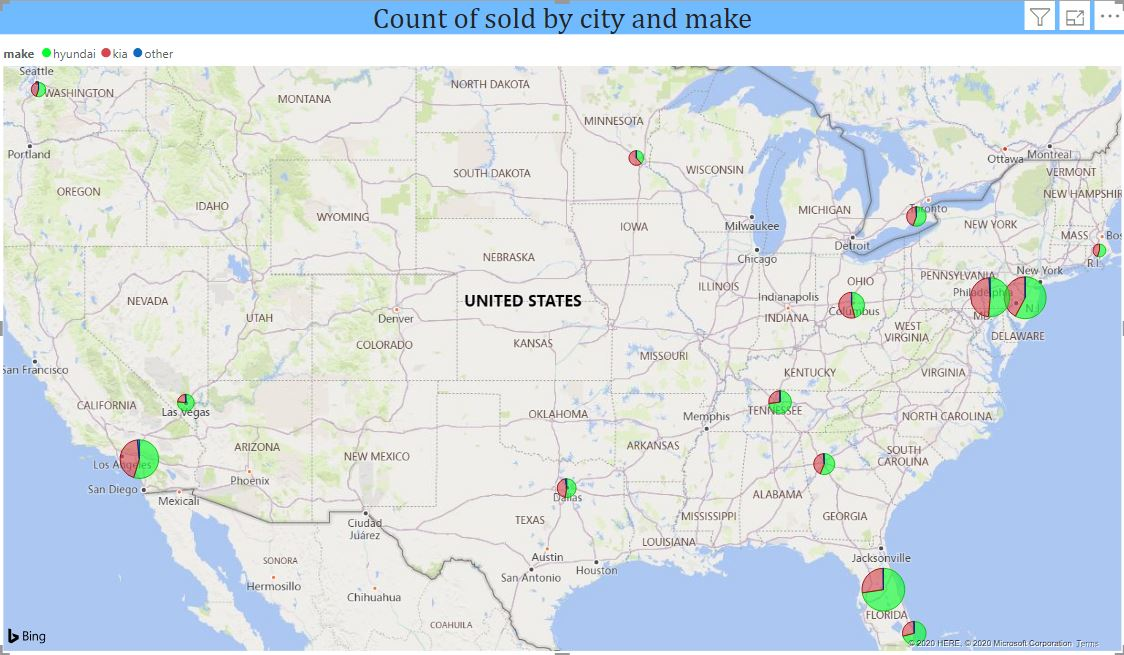

In [44]:
Image(filename='map.jpg')

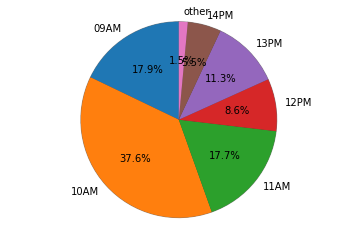

In [45]:
sold = df_copy[df_copy['sold']==1]
P = sold.groupby('sold_hour')['sold'].count().reset_index()
P['Percentage'] = 100 * P['sold']  / P['sold'].sum()

labels = P['sold_hour']
sizes = P['Percentage']
explode = (0, 0, 0, 0, 0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')


plt.rc("font", size=10)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,radius=3 * 10000)
ax1.axis('equal')  

plt.show()

In [46]:
corr = df_copy.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,dmpostcond,dmprecond,smiles,sold,sfloor,SALE_NUM,LANE_NUM,RUN_NUM,DSO,MMR,AdjMMR,abnormal,days_between_arrival_and_offer
dmpostcond,1,0.91,-0.26,0.065,0.34,0.016,-0.037,-0.44,0.093,0.22,0.34,-0.43,-0.012
dmprecond,0.91,1,-0.24,0.072,0.32,0.007,-0.01,-0.38,0.091,0.22,0.34,-0.37,-0.057
smiles,-0.26,-0.24,1,-0.045,-0.24,-0.011,0.0077,0.24,-0.13,-0.26,-0.27,0.046,-0.00053
sold,0.065,0.072,-0.045,1,-0.1,-0.091,-0.0034,-0.042,-0.061,-0.074,-0.058,-0.023,-0.052
sfloor,0.34,0.32,-0.24,-0.1,1,-0.02,-0.057,-0.16,0.15,0.95,0.95,-0.11,0.042
SALE_NUM,0.016,0.007,-0.011,-0.091,-0.02,1,0.32,0.032,0.029,-0.011,-0.012,0.019,0.092
LANE_NUM,-0.037,-0.01,0.0077,-0.0034,-0.057,0.32,1,0.17,-0.076,-0.028,-0.029,0.049,-0.085
RUN_NUM,-0.44,-0.38,0.24,-0.042,-0.16,0.032,0.17,1,-0.048,-0.11,-0.16,0.22,-0.032
DSO,0.093,0.091,-0.13,-0.061,0.15,0.029,-0.076,-0.048,1,0.15,0.15,-0.023,0.059
MMR,0.22,0.22,-0.26,-0.074,0.95,-0.011,-0.028,-0.11,0.15,1,0.99,-0.042,0.052


# Chapter 2 : Classification Performance Metrics

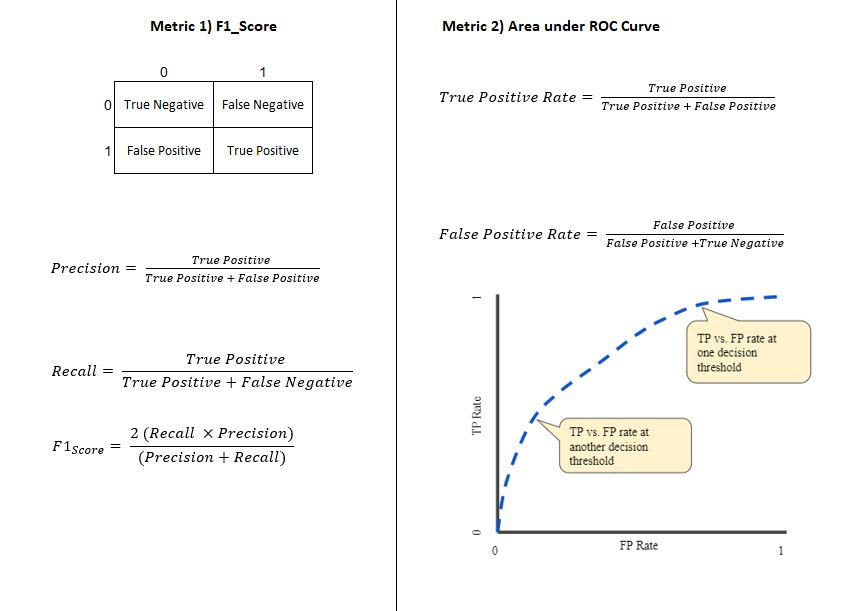

In [38]:
Image(filename='pre_recall.JPG')

# Chapter 3 : Sales Probability Discussion (Logistic Regression)

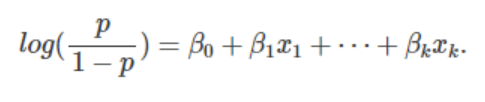

In [39]:
Image(filename='logistic-equation.PNG')

In [40]:
# l1 parameter in lasso regression is used to findout for 
#each l1 term how many features are removed and what is the model f1_score
f1_score_dic = f1_score_calulator(list(np.logspace(-0.001,-3,10)))
f1_score_dic

OrderedDict([(41, '0.8145'),
             (50, '0.8144'),
             (65, '0.8141'),
             (87, '0.8141'),
             (106, '0.8138'),
             (124, '0.8132'),
             (131, '0.8106'),
             (137, '0.8112'),
             (142, '0.8060'),
             (146, '0.8065')])

In [41]:
np.logspace(-0.001,-3,10)

array([ 0.99770006,  0.46320984,  0.21505798,  0.09984661,  0.04635655,
        0.02152231,  0.00999233,  0.00463921,  0.00215388,  0.001     ])

Text(0.5,1,'training error')

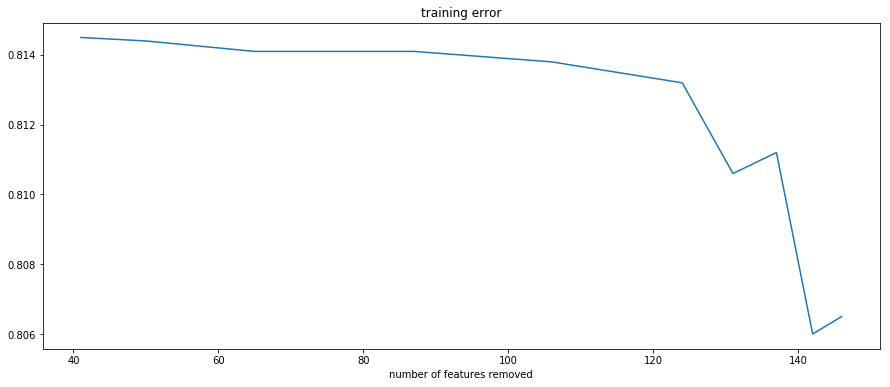

In [42]:
# Plot how training error decreases by removing more and more features
fig, ax = plt.subplots(figsize = (15,6))
feature_removed_list = list(f1_score_dic.keys())
training_error_list = [float(i) for i in f1_score_dic.values()]
ax.plot(feature_removed_list,training_error_list)
# ax.plot(df['date'],df['tablet'])
plt.xlabel('number of features removed')
plt.title('training error')

In [43]:
# Running a Lasso Logistic regression to find out which features should be removed
logmodel = LogisticRegression( penalty = 'l1',solver = 'liblinear',C= 0.04635655)
# Fitting model to traing data
logmodel.fit(X_train,y_train)

LogisticRegression(C=0.04635655, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
log_model_coeff = logmodel.coef_[0].tolist()
selected_features = [col for index,col in enumerate(X_train.columns) if log_model_coeff[index] != 0 ]
print('number of removed features : ', log_model_coeff.count(0))
print('number of remaining features : ', len(selected_features))

number of removed features :  106
number of remaining features :  44


#### Question 2 answered in cell below

In [45]:
selected_features

['dmpostcond',
 'smiles',
 'sfloor',
 'SALE_NUM',
 'DSO',
 'AdjMMR',
 'days_between_arrival_and_offer',
 'city_Bordentown',
 'city_Caledonia',
 'city_Dallas',
 'city_GROVE CITY',
 'city_Kent',
 'city_Las Vegas',
 'city_Manheim',
 'city_Maple Grove',
 'city_Mount Juliet',
 'city_North Dighton',
 'city_Ocoee',
 'city_Riverside',
 'city_West Palm Beach',
 'JD_POWERS_CAT_DESC_SUV',
 'JD_POWERS_CAT_DESC_VAN',
 'JD_POWERS_CAT_DESC_missing',
 'JD_POWERS_SUB_CAT_DESC_missing',
 'color_Black',
 'color_Gray',
 'color_White',
 'color_missing',
 'MID_YEAR_2012',
 'MID_YEAR_2013',
 'MID_YEAR_2016',
 'volseg_Tier3',
 'volseg_Tier5',
 'Velocity_Hot',
 'Velocity_Warm',
 'make_kia',
 'model_elantra',
 'model_optima hybrid',
 'model_rio',
 'model_santa fe fwd',
 'model_veloster',
 'body_optima',
 'body_rio',
 'body_santa fe fwd']

In [46]:
X = X[selected_features]
print(X.shape)

(40403, 44)


In [47]:
# Split training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = seed)
print('size of training dataset : ', X_train.shape)
print('size of training dataset : ', X_test.shape)

size of training dataset :  (36362, 44)
size of training dataset :  (4041, 44)


In [48]:
# Reset the index for X_train and X_test

X_train.reset_index(inplace = True,drop = True)
X_test.reset_index(inplace = True,drop = True)

In [49]:
# Standardize X_train and X_test for continous features that are among the selected_feature list
X_train[[i for i in x_continuous_feature if i in selected_features]] = standardize_df(X_train[[i for i in x_continuous_feature if i in selected_features]])
X_test[[i for i in x_continuous_feature if i in selected_features]] = standardize_df(X_test[[i for i in x_continuous_feature if i in selected_features]])

In [50]:
# Change the format of y_train to a data frame that is usable by statsmodels.logit

y_train_temp = pd.DataFrame(y_train)
y_train_temp.reset_index(inplace = True,drop = True)

#### Question 1 answered in cell below

In [51]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train_temp,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.573443
         Iterations 7
                                                     Results: Logit
Model:                                  Logit                              Pseudo R-squared:                   0.082     
Dependent Variable:                     sold                               AIC:                                41785.0922
Date:                                   2020-03-12 09:46                   BIC:                                42133.6447
No. Observations:                       36362                              Log-Likelihood:                     -20852.   
Df Model:                               40                                 LL-Null:                            -22716.   
Df Residuals:                           36321                              LLR p-value:                        0.0000    
Converged:                              1.0000                             Scale:                 

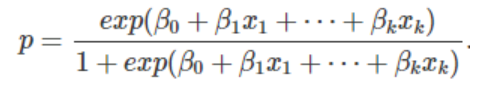

In [52]:
Image(filename='probability.PNG')

# Chapter 4 : Implementation of Bucket of Models 

<font size="+0.9"> <p>

## Algorithm 

#### step 1: determine hyperparametes of data preparation stage
> train_test_split

> Normalizing

> Rreweighting training dataset

> Number of features to include

#### step 2: optimize hyperparameter of each machine learning model using K fold cross validation
#### step 3: train the model using tunned parameters
#### step 4: evaluate each model against test dataset
</font></p>

### 4.1 : Logistic Regression 

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
# define the base model

logmodel = LogisticRegression()

In [55]:
# Define parameters that are needed in K fold cross validation
# penalty = ['l1', 'l2']
# C is Inverse of regularization strength; similar to SVM,  smaller values specify stronger regularization
# C = np.logspace(0,4,10)
hyperparameters = dict(C = np.logspace(0,4,10),
                       penalty = ['l1', 'l2'],
                       solver = ['liblinear']
                      )

In [56]:
# Finding the best hyper parameters for model using 5 fold cross validation

best_params = hyper_parameter_optimizer(logmodel,hyperparameters, 5,'GridSearchCV')
print('Best fitted model using k fold cross validation has the parameters : ', best_params)

Best fitted model using k fold cross validation has the parameters :  {'C': 2.7825594022071245, 'penalty': 'l1', 'solver': 'liblinear'}


In [38]:
# best_params =  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

In [39]:
# Retrain the model using the best parameters
logmodel = LogisticRegression(C = 1, penalty = 'l1',solver = 'liblinear')
# Fitting model to traing data
logmodel.fit(X_train,y_train)
# Predict test data using the trained model
predictions = logmodel.predict(X_test)

#report accuracy dictionary
model_metrics = report_classification_metrics(y_test,predictions, 'logistic', standardize_feature, reweight_training, X_train.shape[1],best_params)
model_metrics

OrderedDict([('model_name', 'logistic'),
             ('test_train_split_threshold', 0.2),
             ('standardize_feature', True),
             ('reweight_training', False),
             ('number_of_featurs', 150),
             ('best_params', {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}),
             ('model_accuracy', '0.7120'),
             ('model_precision', '0.7305'),
             ('model_recall', '0.9228'),
             ('model_f1_score', '0.8155'),
             ('auc_under_roc', '0.5832')])

In [58]:
# if we want to add the current model accuracy metrics to archive, we set the value to True

add_results_to_historical_runs(True,model_metrics)

In [59]:
# report_data_frame.shape

# Model 2 : Decision Trees

In [35]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
# Define the base model
dtree = DecisionTreeClassifier()

In [39]:
# specify the ranger for hyper parameters
# How deep our tree can go
# The minimum number of samples required to split an internal node
# The minimum number of samples required to be at a leaf node
# the number of features to consider when looking for the best split

# max_depth = np.linspace(1, 32, 32, endpoint=True)
# max_features = list(range(1,X_train.shape[1]))

hyperparameters = dict(                       
                       min_samples_split = [2,5,10,20],
                       min_samples_leaf = [1,2,4,8]
                      )

In [40]:
# Finding the best hyper parameters for model using 5 fold cross validation

best_params = hyper_parameter_optimizer(dtree,hyperparameters, 5,'GridSearchCV')
print('Best fitted model using k fold cross validation has the parameters : ', best_params)

Best fitted model using k fold cross validation has the parameters :  {'min_samples_leaf': 8, 'min_samples_split': 20}


In [63]:
# best_params = hyperparameters = {'min_samples_leaf': 8, 'min_samples_split': 20}

In [64]:
# Retrain the model using the best parameters
dtree = DecisionTreeClassifier(min_samples_leaf = 8,

                               min_samples_split = 20)
# Fitting model to traing data
dtree.fit(X_train,y_train)
# Predict test data using the trained model
predictions = dtree.predict(X_test)

model_metrics = report_classification_metrics(y_test,predictions, 'dtree', standardize_feature, reweight_training, X_train.shape[1],best_params)
model_metrics

OrderedDict([('model_name', 'dtree'),
             ('test_train_split_threshold', 0.2),
             ('standardize_feature', True),
             ('reweight_training', False),
             ('number_of_featurs', 44),
             ('best_params', {'min_samples_leaf': 32, 'min_samples_split': 5}),
             ('model_accuracy', '0.6790'),
             ('model_precision', '0.7337'),
             ('model_recall', '0.8397'),
             ('model_f1_score', '0.7832'),
             ('auc_under_roc', '0.5801')])

In [77]:
# if we want to add the current model accuracy metrics to archive, we set the value to True

add_results_to_historical_runs(True,model_metrics)

# Model 3 : Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
# Define the base model
rfc = RandomForestClassifier()

In [38]:
#  specify the ranger for hyper parameters

max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 10]
# max_depth.append(None)
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]

hyperparameters = dict(                       
                       n_estimators = [110,200,300],
                       max_features = ['auto', 'sqrt'],
                       min_samples_split = [2, 5, 10]
                       
                      )

In [ ]:
# Finding the best hyper parameters for model using 5 fold cross validation

best_params = hyper_parameter_optimizer(rfc,hyperparameters,5,'RandomizedSearchCV')
print('Best fitted model using k fold cross validation has the parameters : ', best_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] n_estimators=110, min_samples_split=2, max_features=auto ........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=110, min_samples_split=2, max_features=auto, total=   8.0s
[CV] n_estimators=110, min_samples_split=2, max_features=auto ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV]  n_estimators=110, min_samples_split=2, max_features=auto, total=   7.9s
[CV] n_estimators=110, min_samples_split=2, max_features=auto ........
[CV]  n_estimators=110, min_samples_split=2, max_features=auto, total=   8.1s
[CV] n_estimators=110, min_samples_split=2, max_features=auto ........
[CV]  n_estimators=110, min_samples_split=2, max_features=auto, total=   8.8s
[CV] n_estimators=110, min_samples_split=2, max_features=auto ........
[CV]  n_estimators=110, min_samples_split=2, max_features=auto, total=   8.4s
[CV] n_estimators=200, min_samples_split=2, max_features=auto ........
[CV]  n_estimators=200, min_samples_split=2, max_features=auto, total=  16.8s
[CV] n_estimators=200, min_samples_split=2, max_features=auto ........
[CV]  n_estimators=200, min_samples_split=2, max_features=auto, total=  14.5s
[CV] n_estimators=200, min_samples_split=2, max_features=auto ........
[CV]  n_estimators=200, min_samples_split=2, max_features=auto, total=  15.5s
[CV] n_estimators=200, min_s

In [68]:
# best_params = {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt'}

In [69]:
# Retrain the model using the best parameters
rfc = RandomForestClassifier(
                            n_estimators = 200,
                            min_samples_split = 5,
                            max_features = 'sqrt'
    
                            )
# Fitting model to traing data
rfc.fit(X_train,y_train)
# Predict test data using the trained model
predictions = rfc.predict(X_test)

model_metrics = report_classification_metrics(y_test,predictions, 'random_forest', standardize_feature, reweight_training, X_train.shape[1],best_params)
model_metrics

OrderedDict([('model_name', 'random_forest'),
             ('test_train_split_threshold', 0.2),
             ('standardize_feature', True),
             ('reweight_training', False),
             ('number_of_featurs', 44),
             ('best_params',
              {'max_features': 'sqrt',
               'min_samples_split': 5,
               'n_estimators': 200}),
             ('model_accuracy', '0.7272'),
             ('model_precision', '0.7452'),
             ('model_recall', '0.9193'),
             ('model_f1_score', '0.8231'),
             ('auc_under_roc', '0.6091')])

In [70]:
# if we want to add the current model accuracy metrics to archive, we set the value to True

add_results_to_historical_runs(True,model_metrics)

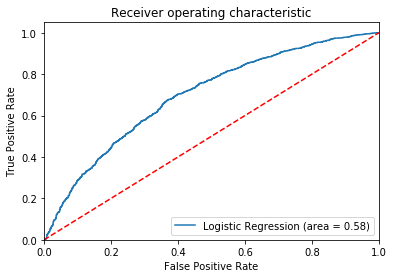

In [71]:
# Plot ROC curve, for every classifier, we want the blue line to stay as away from red line as possible

from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [83]:
# report_data_frame.shape

(20, 11)

# Model 4 : Support Vector Machines

In [72]:
from sklearn.svm import SVC

In [73]:
# Define the base model
svc = SVC()

In [38]:
#  specify the ranger for hyper parameters



hyperparameters = dict(                       
                       C = [0.1,1, 10, 100],
                       gamma = [1,0.1,0.01,0.001]
                      )

In [39]:
best_params = hyper_parameter_optimizer(svc,hyperparameters,2,'RandomizedSearchCV')
print('Best fitted model using k fold cross validation has the parameters : ', best_params)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] gamma=1, C=0.1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... gamma=1, C=0.1, total= 1.6min
[CV] gamma=1, C=0.1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] ................................... gamma=1, C=0.1, total= 1.6min
[CV] gamma=0.1, C=0.1 ................................................
[CV] ................................. gamma=0.1, C=0.1, total=  42.1s
[CV] gamma=0.1, C=0.1 ................................................
[CV] ................................. gamma=0.1, C=0.1, total=  42.5s
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ................................ gamma=0.01, C=0.1, total=  45.8s
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ................................ gamma=0.01, C=0.1, total=  43.9s
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............................... gamma=0.001, C=0.1, total=  54.6s
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............................... gamma=0.001, C=0.1, total=  42.0s
[CV] gamma=1, C=1 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 39.0min finished


Best fitted model using k fold cross validation has the parameters :  {'gamma': 0.01, 'C': 100}


In [75]:
# best_params = {'gamma': 0.01, 'C': 100}

In [76]:
# Retrain the model using the best parameters
svc = SVC(
          C = 100,
          gamma = 0.01
         )
# Fitting model to traing data
svc.fit(X_train,y_train)
# Predict test data using the trained model
predictions = svc.predict(X_test)

model_metrics = report_classification_metrics(y_test,predictions, 'svm', True, reweight_training, X_train.shape[1],best_params)
model_metrics

OrderedDict([('model_name', 'svm'),
             ('test_train_split_threshold', 0.2),
             ('standardize_feature', True),
             ('reweight_training', False),
             ('number_of_featurs', 44),
             ('best_params', {'C': 100, 'gamma': 0.01}),
             ('model_accuracy', '0.7171'),
             ('model_precision', '0.7254'),
             ('model_recall', '0.9498'),
             ('model_f1_score', '0.8225'),
             ('auc_under_roc', '0.5740')])

In [77]:
# if we want to add the current model accuracy metrics to archive, we set the value to True

add_results_to_historical_runs(True,model_metrics)

In [78]:
# report_data_frame.shape

# Model 5 : KNN

In [79]:
from sklearn.neighbors import KNeighborsClassifier

In [80]:
# Define the base model
knn = KNeighborsClassifier()

In [61]:
#  specify the ranger for hyper parameters

# p : integer, optional (default = 2) Power parameter for the Minkowski metric. When p = 1, this is
#    equivalent to using manhattan_distance (l1), and euclidean_distance
#    (l2) for p = 2


hyperparameters = dict(                       
                       n_neighbors = [1,5,15,30],
                       p = [1, 2]
                      )

In [62]:
# Finding the best hyper parameters for model using 5 fold cross validation

best_params = hyper_parameter_optimizer(knn,hyperparameters,2,'GridSearchCV')
print('Best fitted model using k fold cross validation has the parameters : ', best_params)

Best fitted model using k fold cross validation has the parameters :  {'n_neighbors': 30, 'p': 1}


In [82]:
# best_params = {'n_neighbors': 30, 'p': 1}

In [83]:
# Retrain the model using the best parameters
knn = KNeighborsClassifier(
          n_neighbors = 30,
          p = 1
         )
# Fitting model to traing data
knn.fit(X_train,y_train)
# Predict test data using the trained model
predictions = svc.predict(X_test)

model_metrics = report_classification_metrics(y_test,predictions, 'knn', True, reweight_training, X_train.shape[1],best_params)
model_metrics

OrderedDict([('model_name', 'knn'),
             ('test_train_split_threshold', 0.2),
             ('standardize_feature', True),
             ('reweight_training', False),
             ('number_of_featurs', 44),
             ('best_params', {'n_neighbors': 30, 'p': 1}),
             ('model_accuracy', '0.7171'),
             ('model_precision', '0.7254'),
             ('model_recall', '0.9498'),
             ('model_f1_score', '0.8225'),
             ('auc_under_roc', '0.5740')])

In [84]:
# if we want to add the current model accuracy metrics to archive, we set the value to True

add_results_to_historical_runs(True,model_metrics)

In [85]:
# report_data_frame.shape

# Model 6 : Naive Bayes Classifier

In [86]:
from sklearn.naive_bayes import GaussianNB

In [87]:
# Define the base model
nb = GaussianNB()

In [104]:
#  specify the ranger for hyper parameters

# var_smoothing is the Portion of the largest variance of all features that is added to variances for calculation stability.



hyperparameters = dict(                       
                       var_smoothing = [1e-12,1e-9,1e-6,1e-3]
                      )

In [105]:
# Finding the best hyper parameters for model using 5 fold cross validation

best_params = hyper_parameter_optimizer(nb,hyperparameters,5,'GridSearchCV')
print('Best fitted model using k fold cross validation has the parameters : ', best_params)

Best fitted model using k fold cross validation has the parameters :  {'var_smoothing': 1e-12}


In [89]:
# best_params = {'var_smoothing': 1e-12}

In [90]:
# Retrain the model using the best parameters
nb = GaussianNB(
          var_smoothing = 1e-12
         )
# Fitting model to traing data
nb.fit(X_train,y_train)
# Predict test data using the trained model
predictions = svc.predict(X_test)

model_metrics = report_classification_metrics(y_test,predictions, 'naive_bayes', True, reweight_training, X_train.shape[1],best_params)
model_metrics

OrderedDict([('model_name', 'naive_bayes'),
             ('test_train_split_threshold', 0.2),
             ('standardize_feature', True),
             ('reweight_training', False),
             ('number_of_featurs', 44),
             ('best_params', {'var_smoothing': 1e-12}),
             ('model_accuracy', '0.7171'),
             ('model_precision', '0.7254'),
             ('model_recall', '0.9498'),
             ('model_f1_score', '0.8225'),
             ('auc_under_roc', '0.5740')])

In [91]:
# if we want to add the current model accuracy metrics to archive, we set the value to True

add_results_to_historical_runs(True,model_metrics)

In [92]:
# report_data_frame.shape

# Model 7 : Neaural Network

In [96]:
# import keras library

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [97]:
# Keras requires numpy arrays instead of data frame

all_features = X_train.values
all_classes = y_train.values

In [98]:
# Here the topology of neaural network is specified. Number of layers and neurons in each model

def create_model():
    model = Sequential()
    #first layer 
    model.add(Dense(88, input_dim=44, kernel_initializer='normal', activation='relu'))
    # second hidden layer
    model.add(Dense(44, kernel_initializer='normal', activation='relu'))
    # third hidden layer
    model.add(Dense(22, kernel_initializer='normal', activation='relu'))
    # Another hidden layer 
#     model.add(Dense(11, kernel_initializer='normal', activation='relu'))
#    Output layer with a binary classification (sold or not sold)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [99]:
# Fitting the model on training dataset

estimator = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)
estimator.fit(all_features, all_classes)

In [100]:
# This dictionary is used for archiving purpose only

best_params = {'layer1' : 88,'layer2' : 44,'layer3' : 22,'layer4':1}

In [101]:
# Making prediction using the trainded model and report the accuracy

predictions = estimator.predict(X_test)

model_metrics = report_classification_metrics(y_test,predictions, 'deep_learning', True, reweight_training, X_train.shape[1],best_params)
model_metrics

OrderedDict([('model_name', 'deep_learning'),
             ('test_train_split_threshold', 0.2),
             ('standardize_feature', True),
             ('reweight_training', False),
             ('number_of_featurs', 44),
             ('best_params',
              {'layer1': 88, 'layer2': 44, 'layer3': 22, 'layer4': 1}),
             ('model_accuracy', '0.6854'),
             ('model_precision', '0.7512'),
             ('model_recall', '0.8139'),
             ('model_f1_score', '0.7813'),
             ('auc_under_roc', '0.6064')])

In [102]:
# if we want to add the current model accuracy metrics to archive, we set the value to True

add_results_to_historical_runs(True,model_metrics)

In [103]:
# report_data_frame.shape

# Chapter 5: What is the Take for Clients

In [104]:
# We use the model with highest performance to predict probability of being sold for test dataset

In [40]:
# Define the base model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
best_params = {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt'}

In [41]:
# In this cell we show a dataframe that has y, y_hat, and the probability of being sold for 
# test dataset. My model has never ever seen my test dataset before. 

rfc = RandomForestClassifier(
                            n_estimators = 200,
                            min_samples_split = 5,
                            max_features = 'sqrt'
    
                            )
# Fitting model to traing data
rfc.fit(X_train,y_train)
# Predict test data using the trained model
predictions = rfc.predict(X_test)

predictions_prob = rfc.predict_proba(X_test)
predictions_prob = pd.DataFrame(predictions_prob,columns = ['0','model_prob'])

y = y_test
y.reset_index(inplace=True, drop=True)


y_hat = pd.Series(predictions, name = 'y_hat')
y_hat_pred = pd.Series(predictions, name = 'pred')

frames = [y,y_hat,predictions_prob[['model_prob']],X_test]
result = pd.concat(frames,axis=1)
result[0:20]

,sold,y_hat,model_prob,dmpostcond,smiles,sfloor,SALE_NUM,DSO,AdjMMR,days_between_arrival_and_offer,city_Bordentown,city_Caledonia,city_Dallas,city_GROVE CITY,city_Kent,city_Las Vegas,city_Manheim,city_Maple Grove,city_Mount Juliet,city_North Dighton,city_Ocoee,city_Riverside,city_West Palm Beach,JD_POWERS_CAT_DESC_SUV,JD_POWERS_CAT_DESC_VAN,JD_POWERS_CAT_DESC_missing,JD_POWERS_SUB_CAT_DESC_missing,color_Black,color_Gray,color_White,color_missing,MID_YEAR_2012,MID_YEAR_2013,MID_YEAR_2016,volseg_Tier3,volseg_Tier5,Velocity_Hot,Velocity_Warm,make_kia,model_elantra,model_optima hybrid,model_rio,model_santa fe fwd,model_veloster,body_optima,body_rio,body_santa fe fwd
0,1,1,0.58,0.32,-0.12,-0.05,-0.99,-0.26,-0.02,-0.20,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,0.57,0.32,0.85,0.13,0.38,-0.46,0.29,-0.85,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,1,1,0.81,-2.56,-0.44,-0.76,0.09,0.11,-0.73,-0.80,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
3,1,1,0.74,0.32,0.72,-1.01,1.66,-0.25,-0.90,-0.75,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,1,1,0.52,-2.56,0.52,-0.38,-0.99,-0.30,-0.79,2.17,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
5,1,1,0.73,0.32,0.78,1.17,-0.89,0.13,0.99,-1.26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,1,1,0.53,0.32,-1.71,-0.12,-0.79,0.43,-0.22,0.86,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
7,1,1,0.64,0.32,-0.34,0.05,-1.48,-0.28,-0.06,0.11,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,1,1,0.73,0.32,0.88,-0.35,0.29,-0.42,-0.65,-0.25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,1,1,0.81,0.32,-1.49,0.16,0.77,0.30,0.12,0.06,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [43]:
print('first row of test :')
first_row_of_test

first row of test :


,dmpostcond,smiles,sfloor,SALE_NUM,DSO,AdjMMR,days_between_arrival_and_offer,city_Bordentown,city_Caledonia,city_Dallas,city_GROVE CITY,city_Kent,city_Las Vegas,city_Manheim,city_Maple Grove,city_Mount Juliet,city_North Dighton,city_Ocoee,city_Riverside,city_West Palm Beach,JD_POWERS_CAT_DESC_SUV,JD_POWERS_CAT_DESC_VAN,JD_POWERS_CAT_DESC_missing,JD_POWERS_SUB_CAT_DESC_missing,color_Black,color_Gray,color_White,color_missing,MID_YEAR_2012,MID_YEAR_2013,MID_YEAR_2016,volseg_Tier3,volseg_Tier5,Velocity_Hot,Velocity_Warm,make_kia,model_elantra,model_optima hybrid,model_rio,model_santa fe fwd,model_veloster,body_optima,body_rio,body_santa fe fwd
0,4.00,"30,281.00","12,300.00",32.00,46.00,"12,230.00",27.00,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [107]:
# Lets create a datapoint that neither exists in my training nor in my test dataset. The first row of 
#test dataset is used to create an imaginary dataset (which might be given to us by client next week for example). 
# First row has standardized sfloor of -0.05 which is equivalentt to $12300. In the second row
# we increase the sfloor to $13,800 which is eauivalent to 0.33 in standardized form. 

first_row = X_test[0:1]
# This is the average and std of non standardized sfloor for training data set 
print('mean of sloor',sfloor_mean,'std of sfloor',sfloor_std)

# let us increase the price of this car by $1500 and create a new dataset in out sample. #
new_standardized_sfloor = (13800-12508.5042)/3921.00
print('standardized sfloor of $13300 is ',new_standardized_sfloor)
second_row = first_row.copy()
second_row.ix[0,'sfloor'] = new_standardized_sfloor

# append the first and second data points
old_and_new_data_set = first_row.append(second_row).reset_index(drop = True)
old_and_new_data_set

mean of sloor 12508.504207660417 std of sfloor 3921.007379569528
standardized sfloor of $13300 is  0.3293791889824026


,dmpostcond,smiles,sfloor,SALE_NUM,DSO,AdjMMR,days_between_arrival_and_offer,city_Bordentown,city_Caledonia,city_Dallas,city_GROVE CITY,city_Kent,city_Las Vegas,city_Manheim,city_Maple Grove,city_Mount Juliet,city_North Dighton,city_Ocoee,city_Riverside,city_West Palm Beach,JD_POWERS_CAT_DESC_SUV,JD_POWERS_CAT_DESC_VAN,JD_POWERS_CAT_DESC_missing,JD_POWERS_SUB_CAT_DESC_missing,color_Black,color_Gray,color_White,color_missing,MID_YEAR_2012,MID_YEAR_2013,MID_YEAR_2016,volseg_Tier3,volseg_Tier5,Velocity_Hot,Velocity_Warm,make_kia,model_elantra,model_optima hybrid,model_rio,model_santa fe fwd,model_veloster,body_optima,body_rio,body_santa fe fwd
0,0.34,-0.12,-0.05,-1.00,-0.26,-0.02,-0.20,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.34,-0.12,0.33,-1.00,-0.26,-0.02,-0.20,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [108]:
# Let's predict probabality for the new dataset
# As can be seen, when price increased from $12,300 to $13,800 probability of being sold shrank so much. 

predictions_prob = rfc.predict_proba(old_and_new_data_set)
predictions_prob = pd.DataFrame(predictions_prob,columns = ['0','model_prob'])


y_hat = pd.Series(rfc.predict(old_and_new_data_set), name = 'y_hat')
# y_hat_pred = pd.Series(predictions, name = 'pred')

frames = [y_hat,predictions_prob[['model_prob']],old_and_new_data_set]
result = pd.concat(frames,axis=1)
result[0:20]

,y_hat,model_prob,dmpostcond,smiles,sfloor,SALE_NUM,DSO,AdjMMR,days_between_arrival_and_offer,city_Bordentown,city_Caledonia,city_Dallas,city_GROVE CITY,city_Kent,city_Las Vegas,city_Manheim,city_Maple Grove,city_Mount Juliet,city_North Dighton,city_Ocoee,city_Riverside,city_West Palm Beach,JD_POWERS_CAT_DESC_SUV,JD_POWERS_CAT_DESC_VAN,JD_POWERS_CAT_DESC_missing,JD_POWERS_SUB_CAT_DESC_missing,color_Black,color_Gray,color_White,color_missing,MID_YEAR_2012,MID_YEAR_2013,MID_YEAR_2016,volseg_Tier3,volseg_Tier5,Velocity_Hot,Velocity_Warm,make_kia,model_elantra,model_optima hybrid,model_rio,model_santa fe fwd,model_veloster,body_optima,body_rio,body_santa fe fwd
0,1,0.56,0.34,-0.12,-0.05,-1.00,-0.26,-0.02,-0.20,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0.45,0.34,-0.12,0.33,-1.00,-0.26,-0.02,-0.20,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


<font size="+0.9"> <p>

# Recommendation for Future Research 

* #### bringing more features such as day of week, MMR, columns with text
* #### including more machine learning techniques such as Boosting or stacking
* #### fitting more sophistaceted mode trough running these algorithms on Spark
</font></p>

# Save Results to a CSV File

In [109]:
# report_data_frame.shape

In [149]:
# Replace the file different_models_evaluations that has historical results with a new csv file that has 
# alos results of new fitted models

report_data_frame.to_csv('different_models_evaluations.csv',index=False)